In [13]:
import bayes3d as b
import os
import jax.numpy as jnp
import jax
from tqdm import tqdm
import numpy as np
import pickle
import matplotlib
import matplotlib.animation as animation
import matplotlib.pyplot as plt
from IPython.display import HTML
import PIL

In [10]:
def display_video(frames, framerate=30):
    if type(frames[0]) == PIL.Image.Image:
      frames = [np.array(frames[i]) for i in range(len(frames))]
    height, width, _ = frames[0].shape
    dpi = 70
    orig_backend = matplotlib.get_backend()
    matplotlib.use('Agg')  # Switch to headless 'Agg' to inhibit figure rendering.
    fig, ax = plt.subplots(1, 1, figsize=(width / dpi, height / dpi), dpi=dpi)
    matplotlib.use(orig_backend)  # Switch back to the original backend.
    ax.set_axis_off()
    ax.set_aspect('equal')
    ax.set_position([0, 0, 1, 1])
    im = ax.imshow(frames[0])
    def update(frame):
      im.set_data(frame)
      return [im]
    interval = 1000/framerate
    anim = animation.FuncAnimation(fig=fig, func=update, frames=frames,
                                   interval=interval, blit=True, repeat=True)
    return HTML(anim.to_html5_video())

class RGBD(object):
    def __init__(self, rgb, depth, camera_pose, intrinsics, segmentation=None):
        """RGBD Image
        
        Args:
            rgb (np.array): RGB image
            depth (np.array): Depth image
            camera_pose (np.array): Camera pose. 4x4 matrix
            intrinsics (b.camera.Intrinsics): Camera intrinsics
            segmentation (np.array): Segmentation image
        """
        self.rgb = rgb
        self.depth = depth
        self.camera_pose = camera_pose
        self.intrinsics = intrinsics
        self.segmentation  = segmentation

In [7]:
images = np.load("scene_npzs/passive_physics_shape_constancy_0001_01.npz",allow_pickle=True)["arr_0"]
scene_name = "passive_physics_shape_constancy_0001_01"
imgs = images[85:]

In [20]:
imgs[0].segmentation

array([[2, 2, 2, ..., 2, 2, 2],
       [2, 2, 2, ..., 2, 2, 2],
       [2, 2, 2, ..., 2, 2, 2],
       ...,
       [4, 4, 4, ..., 4, 4, 4],
       [4, 4, 4, ..., 4, 4, 4],
       [4, 4, 4, ..., 4, 4, 4]])

In [14]:
display_video([b.get_rgb_image(imgs[i].rgb) for i in range(len(imgs))])

In [18]:
WALL_Z = 14.5

original_intrinsics = b.Intrinsics(
    400,600, 514.2991467983065,514.2991467983065,300.0,200.0,0.009999999776482582,150.0
)

intrinsics = b.camera.scale_camera_parameters(original_intrinsics, 0.25)
intrinsics = b.Intrinsics(
    intrinsics.height, intrinsics.width,
    intrinsics.fx,
    intrinsics.fy,
    intrinsics.cx,
    intrinsics.cy,
    intrinsics.near,
    WALL_Z + 0.1
)


dx  = 0.7
dy = 0.7
dz = 0.7

# Arijit: C2F happening here   
gridding = [
    b.make_translation_grid_enumeration(
        -dx, -dy, -dz, dx, dy, dz, 21,15,15
    ),
    b.make_translation_grid_enumeration(
        -dx/2.0, -dy/2, -dz/2, dx/2, dy/2, dz/2, 21,15,15
    ),
    b.make_translation_grid_enumeration(
        -dx/10.0, -dy/10, -dz/10, dx/10, dy/10, dz/10, 21,15,15
    )
]

Array([[1.        , 0.        , 0.        , 0.14      ],
       [0.        , 1.        , 0.        , 0.15      ],
       [0.        , 0.        , 1.        , 0.25000003],
       [0.        , 0.        , 0.        , 1.        ]], dtype=float32)

In [19]:
def get_object_mask(point_cloud_image, segmentation, segmentation_ids):
    object_mask = jnp.zeros(point_cloud_image.shape[:2])
    object_ids = []
    for id in segmentation_ids:
        point_cloud_segment = point_cloud_image[segmentation == id]
        bbox_dims, pose = b.utils.aabb(point_cloud_segment)
        # some heuristic to detect the occluder
        is_occluder = jnp.logical_or(
            jnp.logical_or(
                jnp.logical_or(
                    jnp.logical_or(
                    (bbox_dims[0] < 0.1),
                    (bbox_dims[1] < 0.1)
                    ),
                (bbox_dims[1] > 1.1)
                ),
            (bbox_dims[0] > 1.1)
            ),
        (bbox_dims[2] > 2.1)
        )
        if not is_occluder:
            object_mask += (segmentation == id)
            object_ids.append(id)

    object_mask = jnp.array(object_mask) > 0
    return object_ids, object_mask

def prior3(new_pose, prev_pose, prev_prev_pose, bbox_dims):  
    # some prior on the physics (which we are focused on improving)  
    score = 0.0
    new_position = new_pose[:3,3]
    bottom_of_object_y = new_position[1] + bbox_dims[1]/2.0

    prev_position = prev_pose[:3,3]
    prev_prev_position = prev_prev_pose[:3,3]

    velocity_prev = (prev_position - prev_prev_position) * jnp.array([1.0, 1.0, 0.25])
    velocity_with_gravity = velocity_prev + jnp.array([-jnp.sign(velocity_prev[0])*0.01, 0.02, 0.0])

    velocity_with_gravity2 = velocity_with_gravity * jnp.array([1.0 * (jnp.abs(velocity_with_gravity[0]) > 0.1), 1.0, 1.0 ])
    velocity = velocity_with_gravity2

    pred_new_position = prev_position + velocity

    score = score + jax.scipy.stats.multivariate_normal.logpdf(
        new_position, pred_new_position, jnp.diag(jnp.array([0.02, 0.02, 0.02]))
    )
    score += -100.0 * (bottom_of_object_y > 1.5)
    return score

prior_jit = jax.jit(prior3)
prior_parallel_jit = jax.jit(jax.vmap(prior3, in_axes=(0, None,  None, None)))

def update_object_positions(OBJECT_POSES, ALL_OBJECT_POSES):
    for known_id in range(OBJECT_POSES.shape[0]):

        current_pose_estimate = OBJECT_POSES[known_id, :, :]

        for gridding_iter in range(len(gridding)):
            all_pose_proposals = [
                jnp.einsum("aij,jk->aik", 
                    gridding[gridding_iter],
                    current_pose_estimate,
                )
            ]
            if gridding_iter == 0:
                for seg_id in object_ids:
                    _, center_pose = b.utils.aabb(point_cloud_image[segmentation==seg_id])
                    all_pose_proposals.append(
                        jnp.einsum("aij,jk->aik", 
                            gridding[gridding_iter],
                            center_pose,
                        )
                    )
            all_pose_proposals = jnp.vstack(all_pose_proposals)

            all_weights = []
            for batch in jnp.array_split(all_pose_proposals,3):
                
                rendered_images = renderer.render_parallel(batch, known_id)[...,:3]
                rendered_images_spliced = b.splice_image_parallel(rendered_images, point_cloud_image_complement)

                weights = b.threedp3_likelihood_parallel_jit(
                    point_cloud_image, rendered_images_spliced, R, OUTLIER_PROB, OUTLIER_VOLUME, 3
                ).reshape(-1)

                prev_pose = ALL_OBJECT_POSES[-1][known_id]
                if ALL_OBJECT_POSES[-2].shape[0] <= known_id:
                    prev_prev_pose =  ALL_OBJECT_POSES[-1][known_id]
                else:
                    prev_prev_pose =  ALL_OBJECT_POSES[-2][known_id]

                weights += prior_parallel_jit(
                    batch, prev_pose, prev_prev_pose, renderer.model_box_dims[known_id]
                ).reshape(-1)

                all_weights.append(weights)
            all_weights = jnp.hstack(all_weights)

            current_pose_estimate = all_pose_proposals[all_weights.argmax()]

        OBJECT_POSES = OBJECT_POSES.at[known_id].set(current_pose_estimate)
    return OBJECT_POSES

def add_new_objects(OBJECT_POSES):
    for seg_id in object_ids:
        average_probability = jnp.mean(pixelwise_probs[segmentation == seg_id])
        print(seg_id, average_probability)

        if average_probability > -10.0: # if the region is of higher probnability (per pixel),  then it is probably not a new object
            print("average_probability ", average_probability)
            continue

        num_pixels = jnp.sum(segmentation == seg_id)
        if num_pixels < 14: # if object is too small, don't count it as an object
            print("num_pixels", num_pixels)
            continue

        rows, cols = jnp.where(segmentation == seg_id)
        distance_to_edge_1 = min(jnp.abs(rows - 0).min(), jnp.abs(rows - intrinsics.height).min())
        distance_to_edge_2 = min(jnp.abs(cols - 0).min(), jnp.abs(cols - intrinsics.width).min())

        point_cloud_segment = point_cloud_image[segmentation == seg_id]
        dims, pose = b.utils.aabb(point_cloud_segment)

        BUFFER = 1

        if distance_to_edge_1 < BUFFER or distance_to_edge_2 < BUFFER:
            print("distance to edge ", distance_to_edge_1, " ", distance_to_edge_2)
            continue # if object is too close to the edge, don't count it as an object

        # create a new object model here
        resolution = 0.01
        voxelized = jnp.rint(point_cloud_segment / resolution).astype(jnp.int32)
        min_z = voxelized[:,2].min()
        depth = voxelized[:,2].max() - voxelized[:,2].min()

        front_face = voxelized[voxelized[:,2] <= min_z+20, :]
        slices = [front_face]
        for i in range(depth):
            slices.append(front_face + jnp.array([0.0, 0.0, i]))
        full_shape = jnp.vstack(slices) * resolution

        print("Seg ID: ", seg_id, "Prob: ", average_probability, " Pixels: ",num_pixels, " dists: ", distance_to_edge_1, " ", distance_to_edge_2, " Pose: ", pose[:3, 3])

        dims, pose = b.utils.aabb(full_shape)
        mesh = b.mesh.make_marching_cubes_mesh_from_point_cloud(
            b.t3d.apply_transform(full_shape, b.t3d.inverse_pose(pose)),
            0.075
        )

        renderer.add_mesh(mesh)
        print("Adding new mesh")

        OBJECT_POSES = jnp.concatenate([OBJECT_POSES, pose[None, ...]], axis=0)
    return OBJECT_POSES

In [ ]:
R = 0.01
OUTLIER_PROB=0.01
OUTLIER_VOLUME=100.0
ALL_OBJECT_POSES = [jnp.zeros((0, 4, 4))]
t = 0

# renderer = b.Renderer(intrinsics)

b.setup_renderer(intrinsics)
renderer = b.RENDERER


Increasing frame buffer size to (width, height, depth) = (160, 128, 1024)


[E rasterize_gl.cpp:121] OpenGL version reported as 4.6


In [ ]:
renderer

In [48]:
for t in tqdm(range(1, len(images))):
    print(f"{t}/{len(images)}")
    image = images[t]
    depth = b.utils.resize(image.depth, intrinsics.height, intrinsics.width)
    point_cloud_image = b.t3d.unproject_depth(depth, intrinsics)
    segmentation = b.utils.resize(image.segmentation, intrinsics.height, intrinsics.width)
    segmentation_ids = jnp.unique(segmentation)
    object_ids, object_mask = get_object_mask(point_cloud_image, segmentation, segmentation_ids)
    b.get_depth_image(1.0 * object_mask)
    depth_complement = depth * (1.0 - object_mask) + intrinsics.far * (object_mask)
    point_cloud_image_complement = b.t3d.unproject_depth(depth_complement, intrinsics)

    OBJECT_POSES = jnp.array(ALL_OBJECT_POSES[-1])
    OBJECT_POSES = update_object_positions(OBJECT_POSES, ALL_OBJECT_POSES)
#     OBJECT_POSES = update_object_positions(OBJECT_POSES, ALL_OBJECT_POSES)
#     OBJECT_POSES = update_object_positions(OBJECT_POSES, ALL_OBJECT_POSES)

    rerendered = renderer.render_multiobject(OBJECT_POSES, jnp.arange(OBJECT_POSES.shape[0]))[...,:3]
    rerendered_spliced = b.splice_image_parallel(jnp.array([rerendered]), point_cloud_image_complement)[0]
    pixelwise_probs = b.threedp3_likelihood_per_pixel_jit(point_cloud_image, rerendered_spliced,  R, 0.0, 1.0, 5)

    OBJECT_POSES = add_new_objects(OBJECT_POSES)
    
    ALL_OBJECT_POSES.append(OBJECT_POSES)

  0%|                                                                                                                | 0/200 [00:00<?, ?it/s]

1/201


: 

: 

In [ ]:
data = []
for t in tqdm(range(len(images))):
    image = images[t]
    depth = b.utils.resize(image.depth, intrinsics.height, intrinsics.width)
    point_cloud_image = b.t3d.unproject_depth(depth, intrinsics)
    segmentation = b.utils.resize(image.segmentation, intrinsics.height, intrinsics.width)
    segmentation_ids = jnp.unique(segmentation)
#     object_ids, object_mask = b.physics.get_object_mask(point_cloud_image, segmentation, segmentation_ids)
    b.get_depth_image(1.0 * object_mask)
    depth_complement = depth * (1.0 - object_mask) + intrinsics.far * (object_mask)
    point_cloud_image_complement = b.t3d.unproject_depth(depth_complement, intrinsics)

    OBJECT_POSES = ALL_OBJECT_POSES[t]
    rerendered = renderer.render_multiobject(OBJECT_POSES, jnp.arange(OBJECT_POSES.shape[0]))
    rerendered_spliced = b.splice_image_parallel(jnp.array([rerendered[...,:3]]), point_cloud_image_complement)[0]
    pixelwise_probs = b.threedp3_likelihood_per_pixel_jit(point_cloud_image, rerendered_spliced, R, 0.0, 1.0, 5)


    weights = []
    if t >= 2:
        for known_id in range(len(ALL_OBJECT_POSES[t])):
            if ALL_OBJECT_POSES[t-1].shape[0] <= known_id:
                continue

            if ALL_OBJECT_POSES[t-2].shape[0] <= known_id:
                continue

            prev_pose = ALL_OBJECT_POSES[t-1][known_id]
            if ALL_OBJECT_POSES[t-2].shape[0] <= known_id:
                prev_prev_pose =  ALL_OBJECT_POSES[t-1][known_id]
            else:
                prev_prev_pose =  ALL_OBJECT_POSES[t-2][known_id]

            weight = prior_jit(
                ALL_OBJECT_POSES[t][known_id],
                ALL_OBJECT_POSES[t-1][known_id],
                ALL_OBJECT_POSES[t-2][known_id],
                renderer.model_box_dims[known_id]
            ).reshape(-1)
            weights.append(weight)

    data.append(
        (
            image.rgb,
            point_cloud_image,
            rerendered,
            rerendered_spliced,
            pixelwise_probs,
            weights
        )
    )
weights_over_time = [jnp.array(d[-1]).sum() for d in data]

100%|██████████████████████████████████| 116/116 [00:04<00:00, 24.95it/s]


In [ ]:
import matplotlib.pyplot as plt
import io
import numpy as np
from PIL import Image
t = 50

def make_plot(x,y, xlabel):
    plt.clf()
    color = np.array([229, 107, 111])/255.0
    plt.plot(x,y, color=color)
    plt.xlim(0, len(images))
    plt.ylim(-800.0, 100.0)
    plt.xlabel("Time",fontsize=20)
    plt.ylabel("Log Probability",fontsize=20)
    plt.tight_layout()
    img_buf = io.BytesIO()
    plt.savefig(img_buf, format='png')
    im = Image.open(img_buf)
    return im


In [ ]:
weights_over_time

[Array(0., dtype=float32),
 Array(0., dtype=float32),
 Array(0., dtype=float32),
 Array(0., dtype=float32),
 Array(0., dtype=float32),
 Array(0., dtype=float32),
 Array(0., dtype=float32),
 Array(0., dtype=float32),
 Array(0., dtype=float32),
 Array(0., dtype=float32),
 Array(0., dtype=float32),
 Array(0., dtype=float32),
 Array(0., dtype=float32),
 Array(0., dtype=float32),
 Array(0., dtype=float32),
 Array(0., dtype=float32),
 Array(0., dtype=float32),
 Array(0., dtype=float32),
 Array(0., dtype=float32),
 Array(0., dtype=float32),
 Array(3.085175, dtype=float32),
 Array(3.0987191, dtype=float32),
 Array(3.100819, dtype=float32),
 Array(3.1008189, dtype=float32),
 Array(3.1008189, dtype=float32),
 Array(3.1008189, dtype=float32),
 Array(3.073119, dtype=float32),
 Array(2.3539624, dtype=float32),
 Array(3.1005938, dtype=float32),
 Array(3.0998127, dtype=float32),
 Array(3.0998127, dtype=float32),
 Array(3.0998127, dtype=float32),
 Array(3.0998127, dtype=float32),
 Array(3.0998127, dty

100%|██████████████████████████████████| 116/116 [00:27<00:00,  4.28it/s]


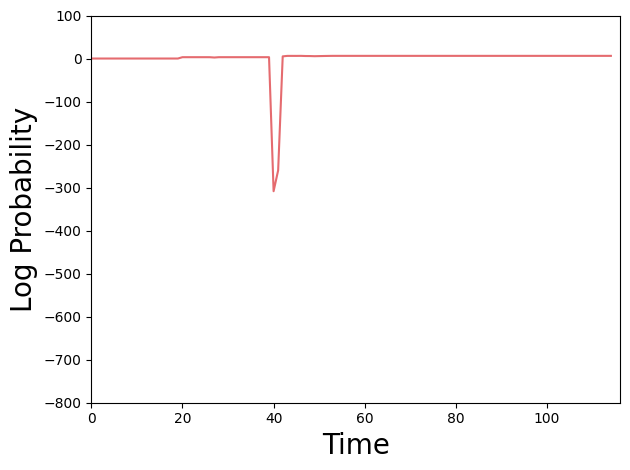

In [ ]:
viz_panels = []
for t in tqdm(range(len(images))):
    rgb, point_cloud_image, rerendered, rerendered_spliced, pixelwise_probs, weights = data[t]
    plots = make_plot(np.arange(t), weights_over_time[:t], "Time")
    factor = rgb.shape[0] / plots.height


    v = b.multi_panel([
        b.get_rgb_image(rgb),
        b.scale_image(b.get_depth_image(rerendered[:,:,2], min=4.0,max=15.0),4),
        b.overlay_image(b.scale_image(b.get_depth_image(rerendered[:,:,2], min=4.0,max=15.0),4), b.get_rgb_image(rgb)),
        b.scale_image(plots, factor)
    ],
    ["Observed RGB", "Inferred Objects", "Overlay", "Probability"],
        label_fontsize=50,
    )
    viz_panels.append(v)
b.make_gif(viz_panels, f"{scene_name}.gif")

In [ ]:
len(ALL_OBJECT_POSES)

116

In [ ]:
b.meshcat.setup_visualizer()

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7000/static/


In [ ]:
b.meshcat.show_trimesh("1",renderer.meshes[1])

NameError: name 'renderer' is not defined

IndexError: list index out of range

0 12.277646
Seg ID:  0 Prob:  12.277646  Pixels:  200  dists:  21   20  Pose:  [-2.4913163  1.141669   6.9488544]
Adding new mesh


In [ ]:
ALL_OBJECT_POSES.append(OBJECT_POSES)


2 13.143784


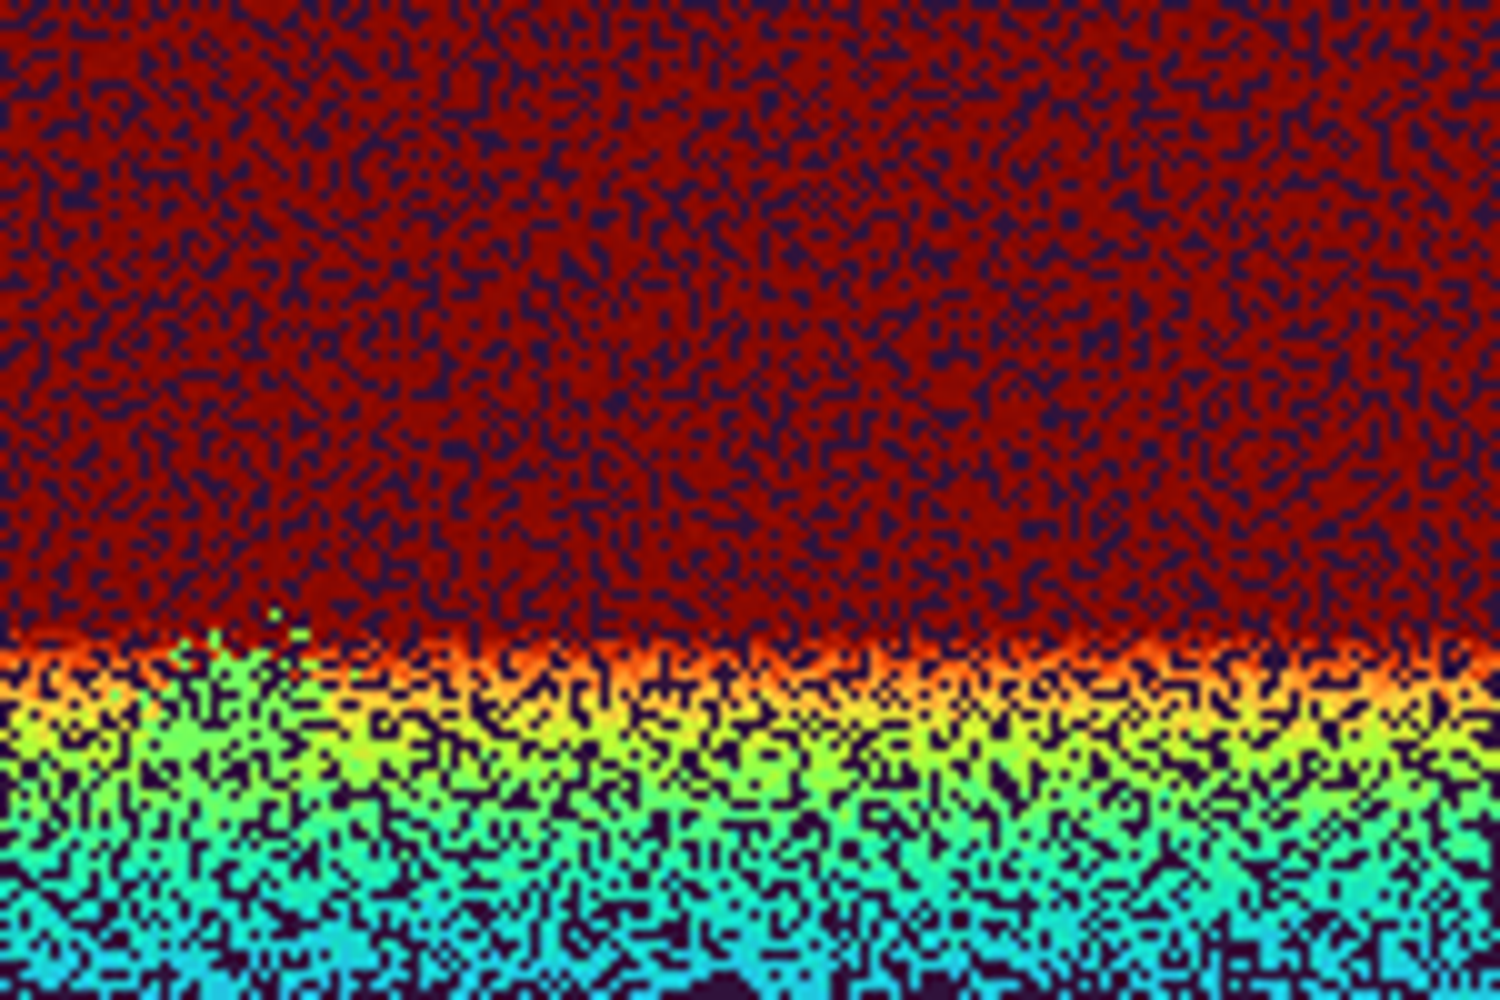

In [ ]:
r = jnp.ones_like(point_cloud_image[:,:,2]) * 0.005
key = jax.random.PRNGKey(10)
noisy_point_cloud_image = jax.random.multivariate_normal(
    key, point_cloud_image[:,:,:3], (jnp.eye(3)[None, None, :, :] * r[:,:,None,None]), shape=r.shape
)
img = b.render_point_cloud(noisy_point_cloud_image.reshape(-1,3), intrinsics)
b.scale_image(b.get_depth_image(img[:,:,2]),10)

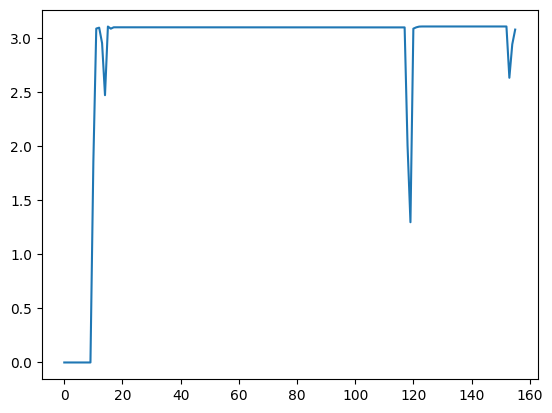

In [ ]:
plt.plot(weights_over_time)